## Goal

* use the mathematical formulation of the optimization task,
* formulate the indicator function and explain how it relates to the outcome
of the classification,
* predict and explain the outcome of using different kernels,
* explain the effect of the C-value when using slack variables.

In [1]:
import numpy as np, random, math, scipy
from scipy.optimize import minimize
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from functools import partial

In [37]:
k_linear = lambda x, y: np.inner(x, y)
k_poly = lambda x, y: (np.inner(x, y) + 1) ** 10
k_rbf = lambda x, y: np.exp(- np.linalg.norm(x - y)**2 / (2 * (300 ** 2)))

In [4]:
def objective(inner, a):
    return (.5 * a * a.reshape(-1, 1) * inner).sum() - a.sum()

In [5]:
def zerofun(t, a):
    return np.dot(a, t)

In [6]:
def calc(k, x, t, c=1):
    N = len(x)
    start = np.zeros(N)
    bounds=[(0, c) for b in range(N)]
    constraint={'type':'eq', 'fun': partial(zerofun, t)} # Input: a
    p = np.multiply(np.einsum('i,j->ij', t, t), np.array([[k(m, n) for m in x] for n in x]))
    cached_obj = partial(objective, p) # Input: a
    res = minimize(cached_obj, start, bounds=bounds, constraints=constraint)
        
    a = res['x']
    indices = np.where(a > 10**-5)
    ai = a[indices]
    xi = inputs[indices]
    ti = targets[indices]
    b = (ai * ti * [k(xi[0], x) for x in xi]).sum() - ti[0]
    def indicator(x, y):
        return (ai * ti * np.array([k(np.array([x, y]), p) for p in xi])).sum() - b
    return indicator

In [7]:
def plot(class_a, class_b, indicator):
    plt.plot([p[0] for p in class_a], [p[1] for p in class_a], 'b.')
    plt.plot([p[0] for p in class_b], [p[1] for p in class_b], 'r.')
    xgrid=np.linspace(-5, 5)
    ygrid=np.linspace(-4, 4)
    grid = np.array([[indicator(x, y) for x in xgrid] for y in ygrid])
    plt.axis('equal')
    plt.contour(xgrid, ygrid, grid, (-1, 0, 1), colors=('red', 'black', 'blue'), linewidths=(1, 3, 1))

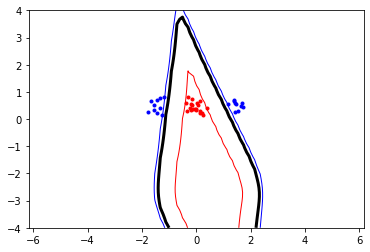

In [38]:
np.random.seed(100)
class_a = np.concatenate((np.random.randn(10, 2) * 0.2 + [1.5, 0.5], np.random.randn(10, 2) * 0.2 + [-1.5, 0.5]))
class_b = np.random.randn(20, 2) * 0.2 + [0.0, 0.5]
inputs = np.concatenate((class_a, class_b))
targets = np.concatenate((np.ones(class_a.shape[0]), -np.ones(class_b.shape[0])))
N = inputs.shape[0]
permute = list(range(N))
random.shuffle(permute)
inputs = inputs[permute, :]
targets = targets[permute]

indicator = calc(k_poly, inputs, targets, c=None)
plot(class_a, class_b, indicator)